In [54]:
from urllib.parse import unquote

import numpy as np
import pandas as pd

import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from matplotlib import pyplot as plt

In [55]:
articles_df = pd.read_csv("data/paths-and-graph/articles.tsv", sep = "\t", comment = '#', header = None)
articles_df.columns = ['article_name']

# Decode names
articles_df['article_name'] = articles_df['article_name'].apply(unquote) 

print(articles_df.shape)
articles_df.head()

(4604, 1)


,article_name
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts


In [56]:
categories_df = pd.read_csv("data/paths-and-graph/categories.tsv", sep = "\t", comment = '#', header = None)
categories_df.columns = ['article_name', 'category']

# Decode article names
categories_df['article_name'] = categories_df['article_name'].apply(unquote)

# Split the 'category' column into multiple columns (one for each level of category)
df_split = categories_df['category'].str.split('.', expand=True).drop(columns=[0])

# Rename the columns to represent each level
df_split.columns = ['Level_1', 'Level_2', 'Level_3']

# Join the new columns with starting dataframe
categories_df = categories_df.drop(columns = ['category']).join(df_split)

print(categories_df.shape)
categories_df.head()

(5204, 4)


,article_name,Level_1,Level_2,Level_3
0,Áedán_mac_Gabráin,History,British_History,British_History_1500_and_before_including_Roma...
1,Áedán_mac_Gabráin,People,Historical_figures,None
2,Åland,Countries,None,None
3,Åland,Geography,European_Geography,European_Countries
4,Édouard_Manet,People,Artists,None


In [57]:
links_df = pd.read_csv("data/paths-and-graph/links.tsv", sep = "\t", comment = '#', header = None)
links_df.columns = ['source', 'target']

# Decode article names
links_df = links_df.map(unquote)

print(links_df.shape)
links_df.head()

(119882, 2)


,source,target
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland


In [58]:
finished_df = pd.read_csv("data/paths-and-graph/paths_finished.tsv", sep = "\t", comment = '#', header = None)
finished_df.columns = ['hashIP', 'timestamp', 'duration', 'path', 'difficulty_rating']

# Decode article names and transform path into list
finished_df['path'] = finished_df['path'].apply(lambda a: [unquote(art) for art in a.split(";")])

# Calculate path length
finished_df['path_length'] = finished_df['path'].apply(len)

# Calculate number of backward clicks in each path
finished_df['num_backward'] = finished_df['path'].apply(lambda a: a.count("<"))

# Convert timestamp to reasonable units 
finished_df['timestamp'] = pd.to_datetime(finished_df['timestamp'], unit='s')

finished_df.head()

,hashIP,timestamp,duration,path,difficulty_rating,path_length,num_backward
0,6a3701d319fc3754,2011-02-15 03:26:49,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,9,0
1,3824310e536af032,2012-08-12 06:36:52,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,5,0
2,415612e93584d30e,2012-10-03 21:10:40,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,8,0
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,4,0
4,015245d773376aab,2013-04-23 15:27:08,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,7,0


In [59]:
unfinished_df = pd.read_csv("data/paths-and-graph/paths_unfinished.tsv", sep = "\t", comment = '#', header = None)
unfinished_df.columns = ['hashIP', 'timestamp', 'duration', 'path', 'target_article', 'type_end']

# Decode article names and transform path to list
unfinished_df['path'] = unfinished_df['path'].apply(lambda a: [unquote(art) for art in a.split(";")])

# Decode article names and transform path to list
unfinished_df['target_article'] = unfinished_df['target_article'].apply(lambda a: unquote(a))

# Calculate length of unfinished paths
unfinished_df['path_length'] = unfinished_df['path'].apply(len)

# Calculate number of backward clicks
unfinished_df['num_backward'] = unfinished_df['path'].apply(lambda a: a.count("<"))

# Convert timestampt to reasonable units 
unfinished_df['timestamp'] = pd.to_datetime(unfinished_df['timestamp'], unit='s')

unfinished_df.head()

,hashIP,timestamp,duration,path,target_article,type_end,path_length,num_backward
0,2426091a53125110,2011-02-07 05:02:15,1804,[Obi-Wan_Kenobi],Microsoft,timeout,1,0
1,26141fd878806294,2011-02-07 05:14:11,1805,[Julius_Caesar],Caracas,timeout,1,0
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout,3,0
3,53a53bc244e08a6a,2011-02-07 16:06:01,49,[Paraguay],Mount_St._Helens,restart,1,0
4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout,2,0


In [60]:
finished_mod = finished_df.copy()

# Keep only paths that are after the first unfinished path (to avoid bias)
finished_mod = finished_mod[finished_mod['timestamp'] > unfinished_df['timestamp'].min()]

# Extract source and target articles
finished_mod['source'] = finished_mod.path.apply(lambda a: a[0])
finished_mod['target'] = finished_mod.path.apply(lambda a: a[-1])

# Add a field that will be used to merge with the unfinished paths
finished_mod['finished'] = True

finished_mod = finished_mod.reindex(sorted(finished_mod.columns), axis=1)
print(finished_mod.shape)
finished_mod.head()

(23245, 10)


,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,source,target,timestamp
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,2011-02-15 03:26:49
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,2012-08-12 06:36:52
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,2012-10-03 21:10:40
4,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,2013-04-23 15:27:08
5,NaN,110,True,5295bca242be81fe,0,"[14th_century, Europe, North_America, United_S...",6,14th_century,John_F._Kennedy,2013-07-03 22:26:54


In [61]:
unfinished_mod = unfinished_df.copy()

# Extract source article
unfinished_mod['source'] = unfinished_mod.path.apply(lambda a: a[0])
unfinished_mod.rename(columns={'target_article': 'target'}, inplace=True)

# Add a field that will be used to merge with the finished paths
unfinished_mod['finished'] = False

unfinished_mod = unfinished_mod.reindex(sorted(unfinished_mod.columns), axis=1)
print(unfinished_mod.shape)
unfinished_mod.head()

(24875, 10)


,duration,finished,hashIP,num_backward,path,path_length,source,target,timestamp,type_end
0,1804,False,2426091a53125110,0,[Obi-Wan_Kenobi],1,Obi-Wan_Kenobi,Microsoft,2011-02-07 05:02:15,timeout
1,1805,False,26141fd878806294,0,[Julius_Caesar],1,Julius_Caesar,Caracas,2011-02-07 05:14:11,timeout
2,1818,False,2b015fb8181c48f2,0,"[Malawi, Democracy, Alexander_the_Great]",3,Malawi,First_Crusade,2011-02-07 15:00:19,timeout
3,49,False,53a53bc244e08a6a,0,[Paraguay],1,Paraguay,Mount_St._Helens,2011-02-07 16:06:01,restart
4,1808,False,53a53bc244e08a6a,0,"[Paraguay, Bolivia]",2,Paraguay,Mount_St._Helens,2011-02-07 17:18:25,timeout


In [62]:
valid_games = pd.concat([finished_mod, unfinished_mod], ignore_index = True)

# Drop the type of the end of the path because it is not relevant
valid_games.drop('type_end', axis = 1, inplace = True)

print(valid_games.shape)
print(valid_games.columns)
valid_games.head()

(48120, 10)
Index(['difficulty_rating', 'duration', 'finished', 'hashIP', 'num_backward',
       'path', 'path_length', 'source', 'target', 'timestamp'],
      dtype='object')


,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,source,target,timestamp
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,2011-02-15 03:26:49
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,2012-08-12 06:36:52
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,2012-10-03 21:10:40
3,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,2013-04-23 15:27:08
4,NaN,110,True,5295bca242be81fe,0,"[14th_century, Europe, North_America, United_S...",6,14th_century,John_F._Kennedy,2013-07-03 22:26:54


In [63]:
from src.graph_processing import construct_adjecency_matrix

articles = articles_df['article_name'].tolist()
adj_matrix = construct_adjecency_matrix(links_df, articles_df['article_name'].tolist())

print(adj_matrix.shape)
adj_matrix.head()

(4604, 4604)


,Áedán_mac_Gabráin,Åland,Édouard_Manet,Éire,Óengus_I_of_the_Picts,€2_commemorative_coins,10th_century,11th_century,12th_century,13th_century,...,Ziad_Jarrah,Zimbabwe,Zinc,Zinc_chloride,Zion_National_Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
Áedán_mac_Gabráin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Åland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Édouard_Manet,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Éire,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Óengus_I_of_the_Picts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
from src.graph_processing import from_adjacency_matrix_to_list, generate_inverse_index_mapping, load_pair_data_with_multiindex

adj_list = from_adjacency_matrix_to_list(adj_matrix)
index_mapping = generate_inverse_index_mapping(adj_list)
pair_data = load_pair_data_with_multiindex('data/pair_stats.txt', index_mapping)

pair_data.head()

shortest_path_length  shortest_path_count  \
source       target                                                    
10th_century 10th_century                     0                    1   
             11th_century                     1                    1   
             12th_century                     2                    5   
             13th_century                     2                    4   
             14th_century                     2                    4   

                           max_sp_node_degree  max_sp_avg_node_degree  \
source       target                                                     
10th_century 10th_century                   0                       0   
             11th_century                  26                      13   
             12th_century                  48                      24   
             13th_century                  79                      35   
             14th_century                  53                      26   

                           avg_sp_avg_node_degree  one_longer_path_count  \
source       target                                                        
10th_century 10th_century                       0                      0   
             11th_century                      13                      2   
             12th_century                      23                    121   
             13th_century                      28                    131   
             14th_century                      22                    113   

                           max_ol_node_degree  max_ol_avg_node_degree  \
source       target                                                     
10th_century 10th_century                   0                       0   
             11th_century                  62                      29   
             12th_century                 180                      93   
             13th_century                 169                      84   
             14th_century                 169                      84   

                           avg_ol_avg_node_degree  two_longer_path_count  \
source       target                                                        
10th_century 10th_century                       0                      0   
             11th_century                      26                      7   
             12th_century                      37                     30   
             13th_century                      39                     30   
             14th_century                      37                     30   

                           max_tl_node_degree  max_tl_avg_node_degree  
source       target                                                    
10th_century 10th_century                   0                       0  
             11th_century                 112                      46  
             12th_century                 169                      70  
             13th_century                 169                      71  
             14th_century                 169                      70

In [91]:
# Merge the pair data with the valid games
valid_games_reg = valid_games.merge(pair_data, left_on = ['source', 'target'], right_index = True, how = 'left')

print(valid_games_reg.shape)
print(valid_games_reg.columns)
# Drop games which do not have shortest_path_length
valid_games_reg.dropna(subset = ['shortest_path_length'], inplace = True)

print("Size after dropping games without shortest path length: ")
print(valid_games_reg.shape)

(48120, 22)
Index(['difficulty_rating', 'duration', 'finished', 'hashIP', 'num_backward',
       'path', 'path_length', 'source', 'target', 'timestamp',
       'shortest_path_length', 'shortest_path_count', 'max_sp_node_degree',
       'max_sp_avg_node_degree', 'avg_sp_avg_node_degree',
       'one_longer_path_count', 'max_ol_node_degree', 'max_ol_avg_node_degree',
       'avg_ol_avg_node_degree', 'two_longer_path_count', 'max_tl_node_degree',
       'max_tl_avg_node_degree'],
      dtype='object')
Size after dropping games without shortest path length: 
(48083, 22)


In [92]:
embeddings_df = pd.read_csv('data/article_embeddings_smaller.csv')

embeddings_df['article_name'] = embeddings_df['article_name'].apply(unquote)
embeddings_df.index = embeddings_df['article_name']
embeddings_df.drop(columns=['article_name'], inplace=True)
embeddings_df.sort_index(inplace=True)

# Turn the embedded value into numpy array
embeddings_df['embedding'] = embeddings_df['embedding'].apply(lambda x: np.asarray(x.replace('[', '').replace(']', '').split(', '), dtype=np.float32))
embeddings_df.head()

,embedding
article_name,
10th_century,"[-0.050105415, 0.09074813, 0.008811204, -0.051..."
11th_century,"[-0.042490385, 0.061723217, -0.020333063, -0.0..."
12th_century,"[-0.032364372, 0.037580367, -0.052070234, -0.1..."
13th_century,"[-0.07914139, 0.059444286, 0.020845776, -0.100..."
14th_century,"[-0.040906686, 0.122400954, -0.04961793, 0.007..."


In [93]:
valid_games_reg = valid_games_reg.join(embeddings_df, on = 'source')
valid_games_reg.rename(columns = {'embedding': 'embedding_source'}, inplace = True)

valid_games_reg = valid_games_reg.join(embeddings_df, on = 'target')
valid_games_reg.rename(columns = {'embedding': 'embedding_target'}, inplace = True)

# Embeddings are normalized so so a dot product is a cosine similarity
valid_games_reg['cosine_similarity'] = valid_games_reg.apply(
    lambda x: np.dot(x['embedding_source'], x['embedding_target']),
    axis=1
)
valid_games_reg.drop(columns=['embedding_source', 'embedding_target'], inplace=True)

print(valid_games_reg.shape)
print(valid_games_reg.columns)
valid_games_reg.head()

(48083, 23)
Index(['difficulty_rating', 'duration', 'finished', 'hashIP', 'num_backward',
       'path', 'path_length', 'source', 'target', 'timestamp',
       'shortest_path_length', 'shortest_path_count', 'max_sp_node_degree',
       'max_sp_avg_node_degree', 'avg_sp_avg_node_degree',
       'one_longer_path_count', 'max_ol_node_degree', 'max_ol_avg_node_degree',
       'avg_ol_avg_node_degree', 'two_longer_path_count', 'max_tl_node_degree',
       'max_tl_avg_node_degree', 'cosine_similarity'],
      dtype='object')


,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,source,target,timestamp,...,max_sp_avg_node_degree,avg_sp_avg_node_degree,one_longer_path_count,max_ol_node_degree,max_ol_avg_node_degree,avg_ol_avg_node_degree,two_longer_path_count,max_tl_node_degree,max_tl_avg_node_degree,cosine_similarity
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,2011-02-15 03:26:49,...,51,47,85,294,98,60,30,172,85,0.202444
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,2012-08-12 06:36:52,...,51,47,85,294,98,60,30,172,85,0.202444
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,2012-10-03 21:10:40,...,51,47,85,294,98,60,30,172,85,0.202444
3,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,2013-04-23 15:27:08,...,103,75,400,294,139,31,30,294,112,0.079502
4,NaN,110,True,5295bca242be81fe,0,"[14th_century, Europe, North_America, United_S...",6,14th_century,John_F._Kennedy,2013-07-03 22:26:54,...,103,75,400,294,139,31,30,294,112,0.079502


In [94]:
node_stats = pd.read_csv('data/paths-and-graph/node_data.tsv', sep='\t')
node_stats.columns = ['article_name', 'degree', 'closeness', 'betweenness', 'pagerank']
node_stats.index = node_stats['article_name']
node_stats.drop(columns=['article_name'], inplace=True)

node_stats.head()

,degree,closeness,betweenness,pagerank
article_name,,,,
11th_century,48,0.33612,6652.300,0.000549
12th_century,45,0.33817,14188.000,0.000722
13th_century,34,0.32159,8543.700,0.000759
14th_century,31,0.32520,5366.200,0.000599
15th_Marine_Expeditionary_Unit,24,0.32701,20.071,0.000035


In [95]:
valid_games_reg = valid_games_reg.join(node_stats, on = 'source')
valid_games_reg = valid_games_reg.join(node_stats, on = 'target', rsuffix = '_target')

valid_games_reg.rename(
    columns = {
        'degree': 'degree_source', 
        'closeness': 'closeness_source', 
        'betweenness': 'betweenness_source', 
        'pagerank': 'pagerank_source'
    }, 
    inplace = True
)

print(valid_games_reg.shape)
print(valid_games_reg.columns)

# Drop games which do not have node statistics
valid_games_reg.dropna(subset = ['degree_source'], inplace = True)
valid_games_reg.dropna(subset = ['degree_target'], inplace = True)
print("Size after dropping games without node statistics: ")
print(valid_games_reg.shape)

(48083, 31)
Index(['difficulty_rating', 'duration', 'finished', 'hashIP', 'num_backward',
       'path', 'path_length', 'source', 'target', 'timestamp',
       'shortest_path_length', 'shortest_path_count', 'max_sp_node_degree',
       'max_sp_avg_node_degree', 'avg_sp_avg_node_degree',
       'one_longer_path_count', 'max_ol_node_degree', 'max_ol_avg_node_degree',
       'avg_ol_avg_node_degree', 'two_longer_path_count', 'max_tl_node_degree',
       'max_tl_avg_node_degree', 'cosine_similarity', 'degree_source',
       'closeness_source', 'betweenness_source', 'pagerank_source',
       'degree_target', 'closeness_target', 'betweenness_target',
       'pagerank_target'],
      dtype='object')
Size after dropping games without node statistics: 
(48072, 31)


In [96]:

# Remove some useless columns
valid_games_reg.drop(columns=['hashIP', 'timestamp', 'duration', 'path', 'difficulty_rating', 'path_length', 'num_backward'], inplace=True)

# Change the type of finished to a float for logistic regression
valid_games_reg['finished'] = valid_games_reg['finished'].astype(float)

print(valid_games_reg.shape)
print(valid_games_reg.columns)

(48072, 24)
Index(['finished', 'source', 'target', 'shortest_path_length',
       'shortest_path_count', 'max_sp_node_degree', 'max_sp_avg_node_degree',
       'avg_sp_avg_node_degree', 'one_longer_path_count', 'max_ol_node_degree',
       'max_ol_avg_node_degree', 'avg_ol_avg_node_degree',
       'two_longer_path_count', 'max_tl_node_degree', 'max_tl_avg_node_degree',
       'cosine_similarity', 'degree_source', 'closeness_source',
       'betweenness_source', 'pagerank_source', 'degree_target',
       'closeness_target', 'betweenness_target', 'pagerank_target'],
      dtype='object')


In [97]:
# Separate the majority and minority classes
majority_class = valid_games_reg.copy()[valid_games_reg['finished'] == False]
minority_class = valid_games_reg.copy()[valid_games_reg['finished'] == True]

# Randomly sample from the majority class to match the minority class size
majority_sampled = majority_class.sample(n=len(minority_class), random_state=42)

# Combine the resampled majority class with the original minority class
balanced_games = pd.concat([majority_sampled, minority_class])

# Shuffle the dataset (optional but recommended)
balanced_games = balanced_games.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
print("New class distribution:\n", balanced_games['finished'].value_counts())

valid_games_reg = balanced_games
print(valid_games_reg.shape)

New class distribution:
 finished
0.0    23236
1.0    23236
Name: count, dtype: int64
(46472, 24)


In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [99]:
def determine_best_thresh(model, x_train, y_train):
    thresholds = np.linspace(0.4, 0.6, 200)
    accuracies = []
    f1_scores = []
    for threshold in thresholds:
        y_pred = model.predict(x_train)
        y_pred = y_pred > threshold
        
        f1_scores.append(f1_score(y_train, y_pred, average='weighted'))
        accuracies.append(accuracy_score(y_train, y_pred))
        
    # Determine the threshold that maximizes the F1 score
    max_f1_score = max(f1_scores)
    max_f1_score_index = f1_scores.index(max_f1_score)
    print("Max F1 Score: ", max_f1_score)
    print(f"Threshold: {thresholds[max_f1_score_index]:.3f}")
        
    plt.plot(thresholds, f1_scores)
    plt.plot(thresholds, accuracies)
    plt.xlabel("Threshold")

In [100]:
x_1 = valid_games_reg.copy()[
    [
        'shortest_path_length',
        'shortest_path_count',
    ]
]
# x_1['shortest_path_count'] = x_1['shortest_path_count'].apply(lambda x: np.exp(x))
x_1['shortest_path_count'] = x_1['shortest_path_count'].apply(lambda x: np.log(x + 1e-4))

y_1 = valid_games_reg['finished']

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_1, y_1, train_size = 0.80, random_state = 42, stratify = y_1)

# standardization
scaler = StandardScaler()

x_train_1 = scaler.fit_transform(x_train_1) # compute z-scores of train set
# x_train_1 = sm.add_constant(x_train_1) 

x_test_1 = scaler.transform(x_test_1) # use the same transformation on test set
# x_test_1 = sm.add_constant(x_test_1)


In [101]:
model_1 = sm.Logit(y_train_1, x_train_1).fit()
model_1.summary()

Optimization terminated successfully.
         Current function value: 0.648290
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               finished   No. Observations:                37177
Model:                          Logit   Df Residuals:                    37175
Method:                           MLE   Df Model:                            1
Date:                Tue, 03 Dec 2024   Pseudo R-squ.:                 0.06472
Time:                        23:38:42   Log-Likelihood:                -24101.
converged:                       True   LL-Null:                       -25769.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7675      0.014    -52.984      0.000      -0.796      -0.739
x2             0.3512      0.013     27.018      0.000       0.326       0.377
==============================================================================
"""

Max F1 Score:  0.6196763354463332
Threshold: 0.503


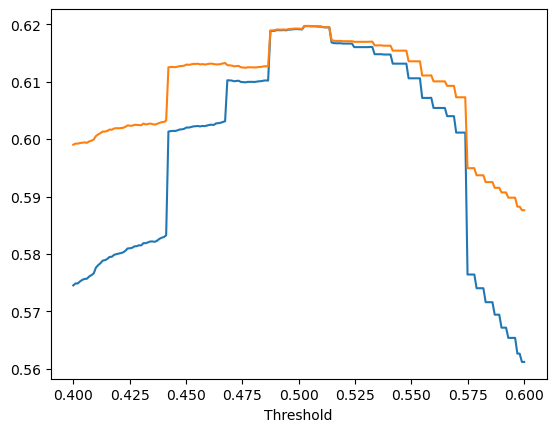

In [102]:
determine_best_thresh(model_1, x_train_1, y_train_1)

In [103]:
# Verify the model on the test set
y_pred_1 = model_1.predict(x_test_1)
threshold_1 = 0.503
y_pred_1 = y_pred_1 > threshold_1
print(classification_report(y_test_1, y_pred_1, digits=3))

              precision    recall  f1-score   support

         0.0      0.624     0.639     0.631      4648
         1.0      0.630     0.615     0.622      4647

    accuracy                          0.627      9295
   macro avg      0.627     0.627     0.627      9295
weighted avg      0.627     0.627     0.627      9295



In [104]:
x_2 = valid_games_reg.copy()[['pagerank_target',]]

y_2 = valid_games_reg['finished']

# standardization
scaler = StandardScaler()

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, train_size = 0.80, random_state = 42, stratify = y_2)

x_train_2 = scaler.fit_transform(x_train_2) 
x_train_2 = sm.add_constant(x_train_2)

x_test_2 = scaler.transform(x_test_2)
x_test_2 = sm.add_constant(x_test_2)

In [105]:
model_2 = sm.Logit(y_train_2, x_train_2).fit()
model_2.summary()

Optimization terminated successfully.
         Current function value: 0.661431
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               finished   No. Observations:                37177
Model:                          Logit   Df Residuals:                    37175
Method:                           MLE   Df Model:                            1
Date:                Tue, 03 Dec 2024   Pseudo R-squ.:                 0.04576
Time:                        23:38:44   Log-Likelihood:                -24590.
converged:                       True   LL-Null:                       -25769.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0579      0.011      5.251      0.000       0.036       0.080
x1             0.7833      0.020     39.044      0.000       0.744       0.823
==============================================================================
"""

Max F1 Score:  0.635927888899219
Threshold: 0.444


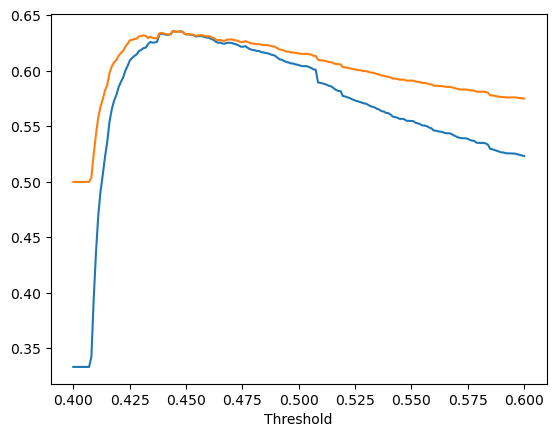

In [106]:
determine_best_thresh(model_2, x_train_2, y_train_2)

In [129]:
# Verify the model on the test set
y_pred_2 = model_2.predict(x_test_2)
threshold_2 = 0.444
y_pred_2 = y_pred_2 > threshold_2
print(classification_report(y_test_2, y_pred_2, digits=3))

              precision    recall  f1-score   support

         0.0      0.643     0.628     0.635      4648
         1.0      0.636     0.652     0.644      4647

    accuracy                          0.640      9295
   macro avg      0.640     0.640     0.640      9295
weighted avg      0.640     0.640     0.640      9295



In [108]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_2, y_pred_2))

[[2917 1731]
 [1618 3029]]


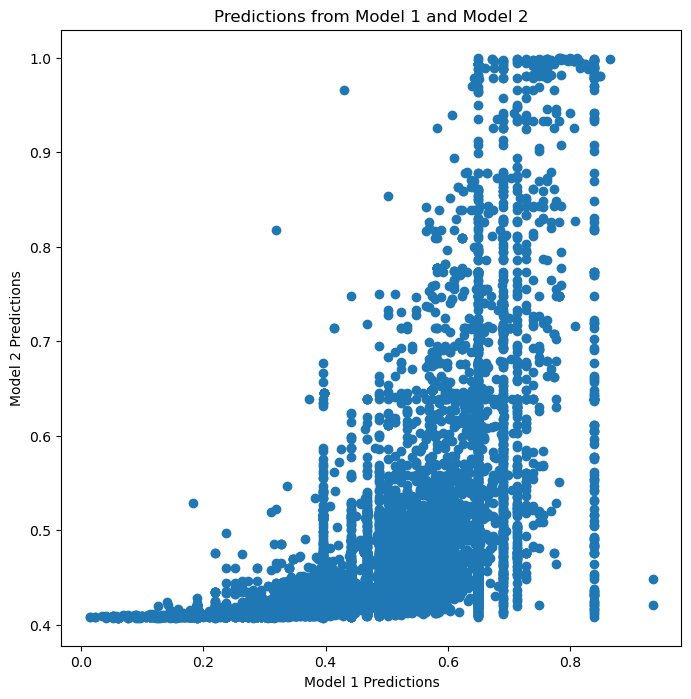

Correlation between the two models:  0.6564671420503199


In [109]:
# Scatterplot the predictions from the two models and calculate correlation
plt.figure(figsize=(8, 8))
plt.scatter(model_1.predict(x_test_1), model_2.predict(x_test_2))
plt.xlabel('Model 1 Predictions')
plt.ylabel('Model 2 Predictions')
plt.title('Predictions from Model 1 and Model 2')
plt.show()

print("Correlation between the two models: ", np.corrcoef(y_pred_1, y_pred_2)[0, 1])

In [111]:
x_big = valid_games_reg.copy().drop(columns=['finished', 'source', 'target'])

y_big = valid_games_reg['finished']

# standardization
scaler = StandardScaler()

x_train_big, x_test_big, y_train_big, y_test_big = train_test_split(x_big, y_big, train_size = 0.80, random_state = 42, stratify = y_big)

x_train_big = scaler.fit_transform(x_train_big) 
x_train_big = sm.add_constant(x_train_big)

x_test_big = scaler.transform(x_test_big)
x_test_big = sm.add_constant(x_test_big)

In [112]:
model_big = sm.Logit(y_train_big, x_train_big).fit()
model_big.summary()

Optimization terminated successfully.
         Current function value: 0.635041
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               finished   No. Observations:                37177
Model:                          Logit   Df Residuals:                    37155
Method:                           MLE   Df Model:                           21
Date:                Tue, 03 Dec 2024   Pseudo R-squ.:                 0.08383
Time:                        23:39:05   Log-Likelihood:                -23609.
converged:                       True   LL-Null:                       -25769.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.011     -0.092      0.927      -0.023       0.021
x1            -0.7665      0.025    -31.121      0.000      -0.815      -0.718
x2             0.1164      0.015      7.817      0.000       0.087       0.146
x3            -0.0285      0.034     -0.836      0.403      -0.095       0.038
x4             0.1157      0.045      2.558      0.011       0.027       0.204
x5            -0.1029      0.024     -4.311      0.000      -0.150      -0.056
x6             0.1972      0.028      7.154      0.000       0.143       0.251
x7            -0.0004      0.019     -0.019      0.985      -0.039       0.038
x8             0.0793      0.026      3.028      0.002       0.028       0.131
x9            -0.0054      0.020     -0.265      0.791      -0.045       0.035
x10            0.0084      0.013      0.636      0.525      -0.017       0.034
x11           -0.0153      0.022     -0.682      0.496      -0.059       0.029
x12            0.0521      0.022      2.326      0.020       0.008       0.096
x13           -0.0204      0.012     -1.656      0.098      -0.044       0.004
x14           -0.0299      0.025     -1.219      0.223      -0.078       0.018
x15           -0.2691      0.022    -12.472      0.000      -0.311      -0.227
x16            0.0863      0.024      3.524      0.000       0.038       0.134
x17           -0.0314      0.022     -1.442      0.149      -0.074       0.011
x18            0.2089      0.025      8.266      0.000       0.159       0.258
x19           -0.1801      0.021     -8.514      0.000      -0.222      -0.139
x20           -0.1945      0.023     -8.329      0.000      -0.240      -0.149
x21            0.3002      0.030     10.115      0.000       0.242       0.358
==============================================================================
"""

Max F1 Score:  0.6341271337933886
Threshold: 0.501


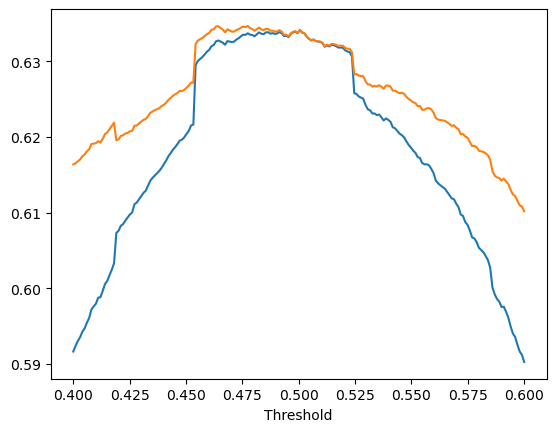

In [113]:
determine_best_thresh(model_big, x_train_big, y_train_big)

In [ ]:
# Verify the model on the test set
y_pred_big = model_big.predict(x_test_big)
threshold_big = 0.501
y_pred_big = y_pred_big > threshold_big
print(classification_report(y_test_big, y_pred_big, digits=4))

              precision    recall  f1-score   support

         0.0     0.6456    0.6310    0.6382      4648
         1.0     0.6391    0.6535    0.6462      4647

    accuracy                         0.6423      9295
   macro avg     0.6424    0.6423    0.6422      9295
weighted avg     0.6424    0.6423    0.6422      9295



In [138]:
print(confusion_matrix(y_test_big, y_pred_big))

[[2637 2011]
 [1319 3328]]


In [139]:
# The third model takes in the predicted values from the first two models and the cosine similarity
combined_pred = valid_games_reg.copy()[['finished']]

x_1_star = valid_games_reg.copy()[['shortest_path_length','shortest_path_count']]
x_1_star['shortest_path_count'] = x_1['shortest_path_count'].apply(lambda x: np.log(x + 1e-4))

scaler = StandardScaler()
x_1_star = scaler.fit_transform(x_1_star)
combined_pred['model_1_pred'] = model_1.predict(x_1_star)
combined_pred['model_1_pred'] = combined_pred['model_1_pred'].apply(lambda x: x ** 2)

x_2_star = valid_games_reg.copy()[['pagerank_target']]
x_2_star = scaler.fit_transform(x_2_star)
x_2_star = sm.add_constant(x_2_star)
combined_pred['model_2_pred'] = model_2.predict(x_2_star)

# Check how accurate the prediction is when both models agree
combined_pred['model_1_pred'] = combined_pred['model_1_pred'] > threshold_1
combined_pred['model_2_pred'] = combined_pred['model_2_pred'] > threshold_2

combined_pred['model_agree'] = ~(combined_pred['model_1_pred'] ^ combined_pred['model_2_pred'])

predictions_align = combined_pred[combined_pred['model_agree'] == True]
predictions_misalign = combined_pred[combined_pred['model_agree'] == False]

# Count how many games are won when both models agree
print("Total number of games:                               ", combined_pred.shape[0])
print()
print("Num of instances when both models agree:              {0}".format(predictions_align.shape[0]))
print("Accuracy when both models agree:                     ", 
      np.sum(predictions_align['model_1_pred'] == predictions_align['finished']) / predictions_align.shape[0]
)

print()
agree_win = np.sum(predictions_align['finished'] == True)
print("Accuracy when both models agree and it is a win:     ",
      np.sum((predictions_align['model_1_pred'] == True) & (predictions_align['finished'] == True)) / agree_win
)
print("Num of instances when its a win and models agree:    ", agree_win)

agree_loss = np.sum(predictions_align['finished'] == False)
print("Accuracy when both models agree and it is a loss:    ",
      np.sum((predictions_align['model_1_pred'] == False) & (predictions_align['finished'] == False)) / agree_loss
)
print("Num of instances when its a loss and models agree:   ", agree_loss)


print()
print("Num of instances when they disagree:                        {0}".format(predictions_misalign.shape[0]))

first_disagree_total = np.sum(predictions_misalign['model_1_pred'] == predictions_misalign['finished'])
print("Accuracy of the first model when they disagree:            ", 
      first_disagree_total / predictions_misalign.shape[0]
)
second_disagree_total = np.sum(predictions_misalign['model_2_pred'] == predictions_misalign['finished'])
print("Accuracy of the second model when they disagree:           ", 
      second_disagree_total / predictions_misalign.shape[0]
)

print()
first_disagree_win = np.sum((predictions_misalign['model_1_pred'] == True) & (predictions_misalign['finished'] == True))
print("Accuracy of first when they disagree and it's a win:       ", 
      first_disagree_win / np.sum(predictions_misalign['finished'] == True)
)
print("Num of instances when its a win and models disagree:       ", first_disagree_win)

second_disagree_win = np.sum((predictions_misalign['model_2_pred'] == True) & (predictions_misalign['finished'] == True))
print("Accuracy of second when they disagree and it's a win:      ",
      second_disagree_win / np.sum(predictions_misalign['finished'] == True)
)
print("Num of instances when its a win and models disagree:       ", second_disagree_win)

first_disagree_loss = np.sum((predictions_misalign['model_1_pred'] == False) & (predictions_misalign['finished'] == False))
print("Accuracy of first when they disagree and it's a loss:      ", 
      first_disagree_loss / np.sum(predictions_misalign['finished'] == False)
)
print("Num of instances when its a loss and models disagree:      ", first_disagree_loss)

second_disagree_loss = np.sum((predictions_misalign['model_2_pred'] == False) & (predictions_misalign['finished'] == False))
print("Accuracy of second when they disagree and it's a loss:     ", 
      second_disagree_loss / np.sum(predictions_misalign['finished'] == False)
)
print("Num of instances when its a loss and models disagree:      ", second_disagree_loss)


      

Total number of games:                                46472

Num of instances when both models agree:              26537
Accuracy when both models agree:                      0.6581376945396993

Accuracy when both models agree and it is a win:      0.26990589938472676
Num of instances when its a win and models agree:     11052
Accuracy when both models agree and it is a loss:     0.9352276396512754
Num of instances when its a loss and models agree:    15485

Num of instances when they disagree:                        19935
Accuracy of the first model when they disagree:             0.39192375219463255
Accuracy of the second model when they disagree:            0.6080762478053674

Accuracy of first when they disagree and it's a win:        0.010587655942219304
Num of instances when its a win and models disagree:        129
Accuracy of second when they disagree and it's a win:       0.9894123440577807
Num of instances when its a win and models disagree:        12055
Accuracy of first whe

In [140]:
from sklearn.ensemble import RandomForestClassifier

X_forrest = valid_games_reg.copy().drop(columns=['finished', 'source', 'target'])
y_forrest = valid_games_reg['finished']

X_train, X_test, y_train, y_test = train_test_split(X_forrest, y_forrest, train_size = 0.80, random_state = 42, stratify = y_forrest)

# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=256, random_state=42, criterion='entropy', n_jobs=-1, max_features=16)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.670     0.586     0.626      4648
         1.0      0.632     0.711     0.670      4647

    accuracy                          0.649      9295
   macro avg      0.651     0.649     0.648      9295
weighted avg      0.651     0.649     0.648      9295

